In [1]:
import numpy as np # Import Numpy for data statistical analysis 
# Numpy is the fundamental package for scientific computing with Python
import pandas as pd # Import Pandas for data manipulation using dataframes
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import json
from pprint import pprint
from langdetect import detect
import urllib

import os
import itertools
import collections
import nltk
from nltk.corpus import stopwords
from nltk import bigrams
# re stands for regular expressions. 
# Regular expressions are a special syntax that is used to identify patterns in a string.
import re
import networkx as nx
from textblob import TextBlob

from nltk import bigrams

import warnings
warnings.filterwarnings("ignore")

sns.set(font_scale=1.5)
sns.set_style("white")

Importing Data from file

In [2]:
with open('dataFiltYt.json') as f:
    data = json.load(f)

In [3]:
df1 = pd.json_normalize((data[i] for i in data.keys()), 'comments')
field = ['commentMadeOn', 'commentText', 'totalLikeCount', 'totalRepliesCount']

data_df = df1[field]

# data_df

In [4]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1265 entries, 0 to 1264
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   commentMadeOn      1265 non-null   object
 1   commentText        1265 non-null   object
 2   totalLikeCount     1265 non-null   int64 
 3   totalRepliesCount  1265 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 39.7+ KB


In [4]:
data_df['commentMadeOn'] = pd.to_datetime(data_df['commentMadeOn'])
data_df['commentDate'] = data_df['commentMadeOn'].dt.date

comFields = ["commentDate", "commentText", "totalLikeCount", "totalRepliesCount"]
com_df = data_df[comFields]

# com_df.sort_values(by = 'commentDate')

In [5]:
com_df['commentDate'] = pd.to_datetime(com_df['commentDate'])
# com_df

In [7]:
com_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1265 entries, 0 to 1264
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   commentDate        1265 non-null   datetime64[ns]
 1   commentText        1265 non-null   object        
 2   totalLikeCount     1265 non-null   int64         
 3   totalRepliesCount  1265 non-null   int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 39.7+ KB


# Comments from 1st March till date

In [6]:
split_date = pd.datetime(2020,2,29)

# pre_df = com_df.loc[com_df['commentDate'] <= split_date]
pre_df = com_df.loc[com_df['commentDate'] > split_date]
pre_df_sorted = pre_df.sort_values(by='commentDate')
# pre_df_sorted

# Language Cleaning

In [7]:
for com in pre_df_sorted['commentText']:
    try:
        language = detect(com)
    except:
        language = "error"
        unDetectable = pre_df_sorted[pre_df_sorted['commentText'] == com].index
        pre_df_sorted.drop(unDetectable, inplace = True)
#         print('The Culprit: ', com)

In [14]:
otherLang = []
for com in pre_df_sorted['commentText']:
    if detect(com) != 'en':
        otherLang.append(pre_df_sorted[pre_df_sorted['commentText'] == com].index)
        
print(len(otherLang))

3


In [15]:
for i in otherLang:
    pre_df_sorted.drop(i, inplace=True)

In [16]:
pre_df_sorted

,commentDate,commentText,totalLikeCount,totalRepliesCount
300,2020-03-04,Bhai cream main kya rate milta hy 1 delevery p...,0,1
734,2020-03-06,Why is that Asian guy talking like that,0,0
731,2020-03-07,Please open your store in Pakistan also,0,0
733,2020-03-07,This food looks amazing! Great story!,0,0
732,2020-03-07,typical Americans thinking they're the only on...,0,0
...,...,...,...,...
115,2020-07-07,"Yumyum, keepsafe always keep vlogging BEBELABS...",0,0
590,2020-07-07,Are there any halal guys shop in Vancouver?,0,0
509,2020-07-09,This is something big bro,1,1
589,2020-07-10,Boycott uber which supress people under occupu...,0,0


# URL and Punctuation Cleaning

In [17]:
def remove_url(txt):
    """Replace URLs found in a text string with nothing 
    (i.e. it will remove the URL from the string).

    Parameters
    ----------
    txt : string
        A text string that you want to parse and remove urls.

    Returns
    -------
    The same txt string with url's removed.
    """

    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())

In [18]:
coms_no_url = [remove_url(text) for text in pre_df_sorted['commentText']]
# print(len(coms_no_url))

In [19]:
coms_nrl_df = pre_df_sorted
# coms_no_url_df.drop(coms_no_url_df.columns[3], axis=1, inplace=True)

coms_nrl_df['commentText'] = coms_no_url
# coms_nrl_df
# coms_no_url_df.columns[3]

In [20]:
coms_nrl_df['characterCount'] = coms_nrl_df.commentText.apply(len)

# coms_nrl_df

# Word Frequency

Making all words lowercase and tokenizing them

In [21]:
#Making all lower case
lower_coms = [com.lower().split() for com in coms_no_url]
# lower_coms[0]

Removing stop words

In [22]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sakir\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [23]:
stop_words = set(stopwords.words('english'))

# Remove stop words from each comment list of words
coms_ns = [[com for com in yt_com if not com in stop_words]
              for yt_com in lower_coms]
# coms_ns[0]

Removing collection words

In [24]:
collection_words = ["talabat", "uber", "eats", "deliveroo", "food", "delivery", "zomato", 
                    "carriage", "middle", "east", "middleeast", "ubereats"]

# Remove collection words from each comment list of words
coms_ncs = [[com for com in yt_com if not com in collection_words]
              for yt_com in coms_ns]

# coms_ncs[0]

Removing Irrelevant words

In [25]:
collection_words = ["guys", "guy", "sauce", "im", "would", "ive", "video", "nyc", "new york", "york", 
              "china", "hot", "ice", "cream", "know", "try", "tried", "india", "chicago", "job", "uk",
                    "australia", "2"]

# Remove collection words from each comment list of words
coms_nics = [[com for com in yt_com if not com in collection_words]
              for yt_com in coms_ncs]

# coms_ncs[0]

In [26]:
# List of all words across Youtube
all_words_coms = list(itertools.chain(*coms_nics))

# Create counter
counts_nics = collections.Counter(all_words_coms)

# counts_no_urls.most_common(15)

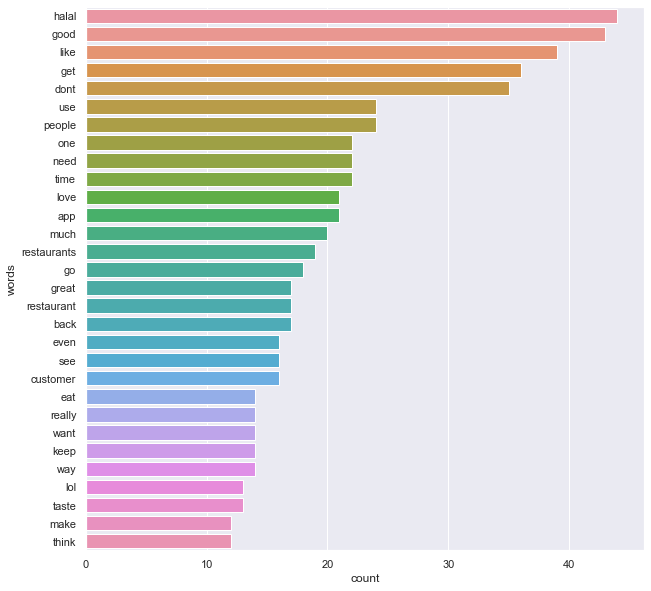

In [27]:
common_words_nics = counts_nics.most_common(30)
clean_coms_nics_df = pd.DataFrame(common_words_nics,
                             columns=['words', 'count'])

# clean_coms_nsw_df.head()
# create the barplot
sns.set(rc={'figure.figsize':(10,10)})
common_words_ax = sns.barplot(x="count", y="words", orient='h', data=clean_coms_nics_df)

# Bigram

In [28]:
from nltk import bigrams

In [29]:
# Create list of lists containing bigrams in tweets
coms_bigram = [list(bigrams(coms)) for coms in coms_nics]

# Flatten list of bigrams in clean tweets
bigrams = list(itertools.chain(*coms_bigram))

# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigrams)

bi_counts = bigram_counts.most_common(16)

In [30]:
bigram_df = pd.DataFrame(bi_counts, columns=['bigram', 'count'])

# bigram_df.head()

### Visualizing Bigram

In [154]:
# Create dictionary of bigrams and their counts
d = bigram_df.set_index('bigram').T.to_dict('records')
# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 11))

# G.add_node("china", weight=100)

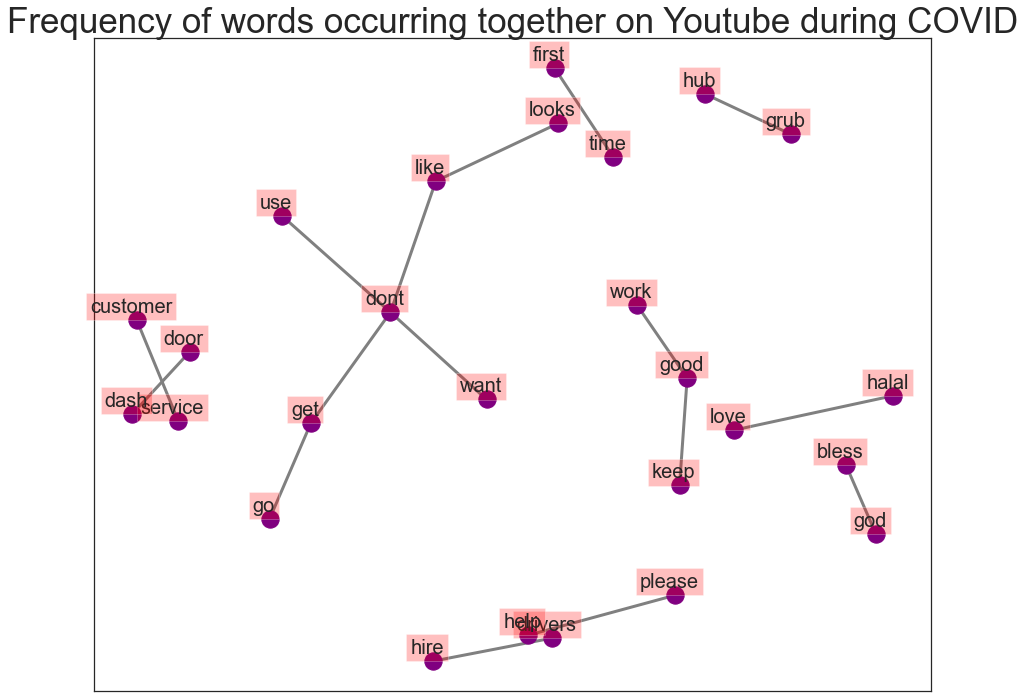

In [199]:
# Draw the network using NetworkX and matplotlib
fig, ax = plt.subplots(figsize=(15, 12))
pos = nx.spring_layout(G, k=2)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=15,
                 width=3,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)
plt.title("Frequency of words occurring together on Youtube during COVID", fontsize=35)

# ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax.set_facecolor('white')
# Create offset labels
for key, value in pos.items():
    x, y = value[0]-0.015, value[1]+0.025
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
        horizontalalignment='center', fontsize=20)
    
plt.show()

# Sentiment Analysis

In [31]:
from textblob import TextBlob

In [32]:
sentiment = [TextBlob(coms) for coms in coms_no_url]
# Create list of polarity valuesx and tweet text
sentiment_values = [round(coms.sentiment.polarity, 1) for coms in sentiment]

# Create dataframe containing the polarity value and tweet text
# sentiment_df = pd.DataFrame(sentiment_values, columns=["polarity", "comments"])
# coms_no_url_df.drop(coms_no_url_df.columns[5], axis=1, inplace=True)
coms_nrl_df['Polarity'] = sentiment_values

# coms_nrl_df

In [33]:
# Remove polarity values equal to zero
coms_nrl_df = coms_nrl_df[coms_nrl_df.Polarity != 0]

# coms_nrl_df.describe()

In [34]:
coms_nrl_df.loc[coms_nrl_df.Polarity > 0.0, 'Sentiment'] = 'Positive'
coms_nrl_df.loc[coms_nrl_df.Polarity < 0.0, 'Sentiment'] = 'Negative'

# coms_nrl_df

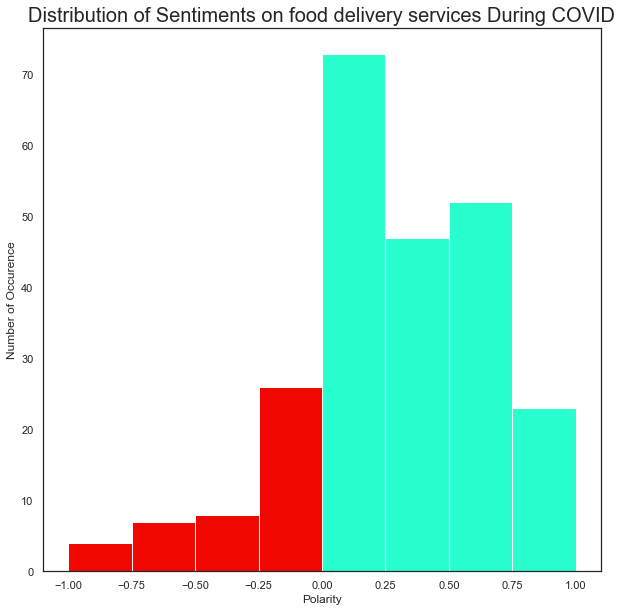

In [109]:
N, bins, patches = plt.hist(coms_nrl_df['Polarity'], 8)

cmap = plt.get_cmap('jet')
low = cmap(0.9)
medium =cmap(0.4)
# high = cmap(0.7)


for i in range(0,4):
    patches[i].set_facecolor(low)
for i in range(4,8):
    patches[i].set_facecolor(medium)

plt.xlabel("Polarity", fontsize=12)  
plt.ylabel("Number of Occurence", fontsize=12)

plt.title("Distribution of Sentiments on food delivery services during COVID", fontsize=16)
ax = plt.subplot(111)  


plt.show()

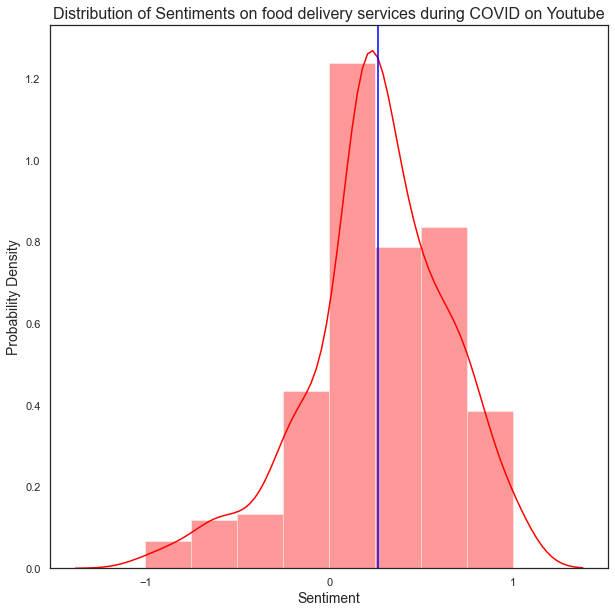

In [35]:
x = coms_nrl_df['Polarity'].values # array with revenues only
sns.set_style("white")
sns.distplot(x, color = 'red', bins=8, kde=True, norm_hist=True); # distplot stands for distribution plot

plt.title("Distribution of Sentiments on food delivery services during COVID on Youtube", fontsize=16)
plt.xlabel("Sentiment", fontsize=14)  
plt.ylabel("Probability Density", fontsize=14)  
plt.xticks([-1,0,1])
# plt.yticks()
# Calculating the mean
mean = coms_nrl_df['Polarity'].mean()

#ploting the mean using matplotlib
plt.axvline(mean, color = 'blue') # axvline: Axis Vertical Line

In [36]:
mean

0.26569037656903766

## Percentage of Positive and Negative

In [94]:
sentiment_p = coms_nrl_df['Polarity'].value_counts(normalize=True, bins=2)*100

sentiment_p

(0.0, 1.0]       81.25
(-1.003, 0.0]    18.75
Name: Polarity, dtype: float64

In [95]:
sentiment_np_df = sentiment_p.to_frame()
sentiment_np_df['Sentiment'] = ["positive", "negative"]
sentiment_np_df

,Polarity,Sentiment
"(0.0, 1.0]",81.25,positive
"(-1.003, 0.0]",18.75,negative


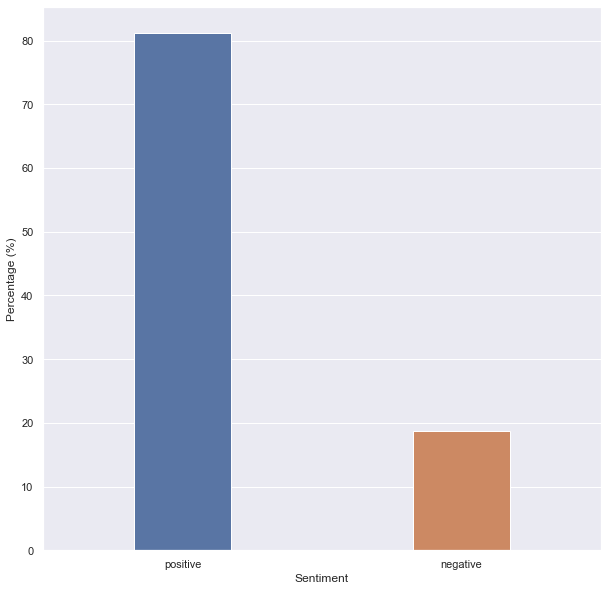

In [96]:
# sentiment_p_df = pd.DataFrame(sentiment_p, columns=["sentiment", "percentage"])
# sentiment_p_df

fig, ax = plt.subplots()

sns.barplot(x="Sentiment", y="Polarity", data=sentiment_np_df, ax=ax)
plt.xlabel("Sentiment", fontsize=12)  
plt.ylabel("Percentage (%)", fontsize=12)
# plt.title("Distribution of Sentiments on food delivery services During COVID", fontsize=15)
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(ax, .35)
    
plt.show()

# Correlation

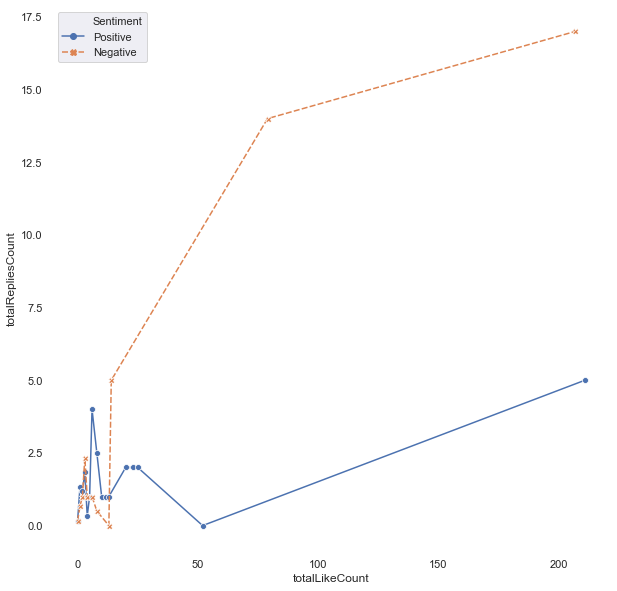

In [97]:
ax = sns.lineplot(x='totalLikeCount', y='totalRepliesCount', hue = 'Sentiment', style = 'Sentiment', data = coms_nrl_df, ci=None,  markers=True)
ax.set_facecolor('white')

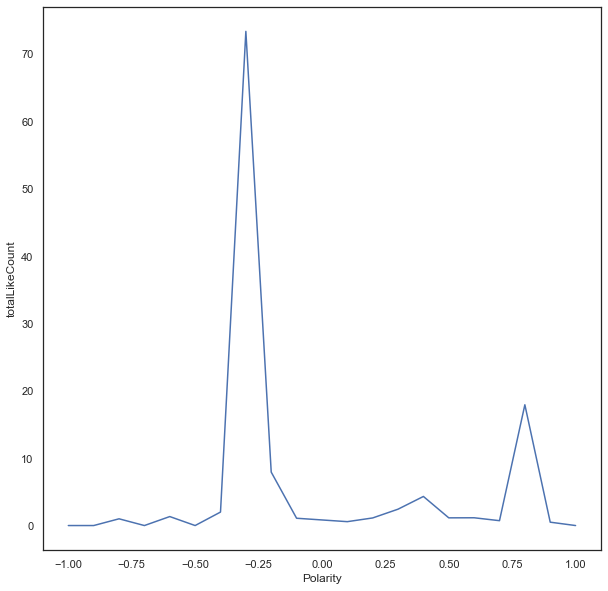

In [103]:
ax = sns.lineplot(x='Polarity', y='totalLikeCount', data = coms_nrl_df, ci=None,  markers=True)
ax.set_facecolor('white')